In [1]:
%load_ext autoreload
%autoreload 2

### In this notebook: 

Checked evaluation of cost functions and noted two discrepancies

1) in old version, x = W @ v produces slightly different x than irfft(z) (confirmed z = conv_v_to_z(z) was the same as in jax version)
2) very large discrepancy between prior portion of cost function for some values of z 

- have now solved discrepancy and have OldMod behaving like Jax (see below)

See next notebook for explanation/investigation of discrepancy, and confirmation that scipy optimization is also corrected

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [6]:
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts_gaussian import load_results

### Data setup

In [7]:
flow = 1
fhigh = 50
scalep_target = 5
scalep_offtarget = 1

gamma_load = pickle_open(f'gammas/k2-full{flow}-{fhigh}-10-{scalep_target}-{scalep_offtarget}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: 'gammas/k2-full1-50-10-5-1.pickle'

In [8]:
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2

In [9]:
scale_init = 10
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 25
init = 'flat-init'
emiters = 20
scale_init = 10
ovs_sel = None

supp = [0, 50]
res_load = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [ ]:
cfg = res_load[ov2]['cfg']
lcfg = cfg.latent
ocfg = cfg.obs

lrk = jr.key(lcfg.seed)
ork = jr.key(ocfg.seed)

### Setting things up for both Jax / Old models


##### Jax model 

##### Old model setup

In [ ]:
def conv_grad_old_r2c(grad_vec_real, K):
    rs = grad_vec_real.reshape(2,-1).swapaxes(0,1)
    grad_vec_complex = conv_v_to_z(rs, axis=0)
    return grad_vec_complex

conv_mus_old_r2c = conv_grad_old_r2c


In [ ]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

old_model_load = load_old(ov2)
Wv = old_model_load['Wv']

In [ ]:
from cohlib.alg.em_sgc import construct_Gamma_full_real, deconstruct_Gamma_full_real
from cohlib.utils import conv_z_to_v, conv_v_to_z
from cohlib.jax.ts import JvOExp, JaxOptim, OldOptim

In [ ]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [ ]:
Nnz = nz.size
nz_target = jnp.array([9])

gamma_inv_true = jnp.zeros_like((gamma_full))
gamma_inv_true = gamma_inv_true.at[nz,:,:].set(jnp.linalg.inv(gamma_full[nz,:,:]))

nz_power_init = 10
gamma_inv_flat = jnp.zeros_like((gamma_full))
gamma_inv_flat_nz = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/nz_power_init)
gamma_inv_flat = gamma_inv_flat.at[nz,:,:].set(gamma_inv_flat_nz)

In [ ]:
L = 25
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2



zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

params_jax = {'freqs': freqs, 'nonzero_inds': nz}
params_old = {'Wv': Wv, 'nonzero_inds': nz}

# jax_exp = JvOExp(obs, gamma_inv_true, obs_var, params_jax, 'jax')
# old_exp = JvOExp(obs, gamma_inv_true, obs_var, params_old, 'old')
gamma_inv_use = gamma_inv_true
jax_exp = JvOExp(obs, gamma_inv_use, obs_var, params_jax, 'jax', track=True)
old_exp = JvOExp(obs, gamma_inv_use, obs_var, params_old, 'old', track=True)
oldmod_exp = JvOExp(obs, gamma_inv_use, obs_var, params_old, 'oldmod', track=True)

jax_exp.e_step(10)
old_exp.e_step(10)
oldmod_exp.e_step(10)

100%|██████████| 25/25 [00:03<00:00,  7.87it/s]


In [ ]:
trial = 0
# zs_test = jnp.zeros((Nnz, K), dtype=complex)
zs_test = zs[nz,:,trial]
omcost, omgrad, omhess = oldmod_exp.eval_cost(trial, zs_test)
ocost, ograd, ohess = old_exp.eval_cost(trial, zs_test)
jcost, jgrad, jhess = jax_exp.eval_cost(trial, zs_test)

So it looks like there were two issues:

#### Original Old Method vs Jax E-Step 0

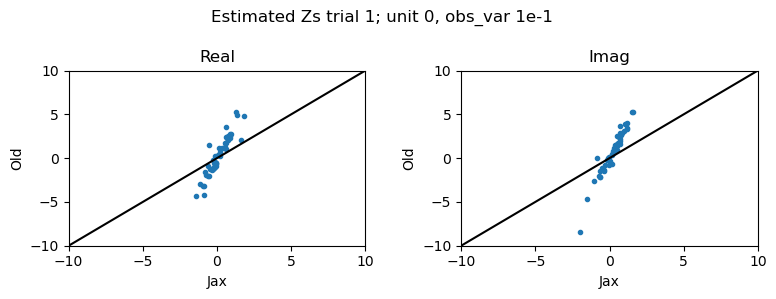

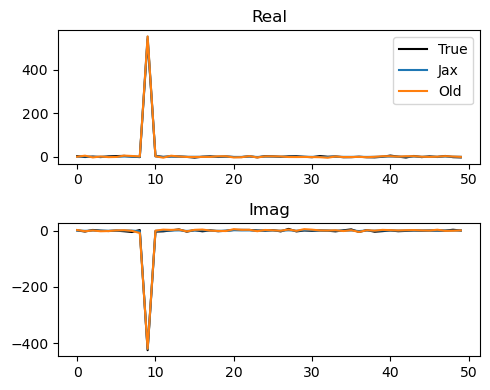

In [ ]:
plim = 10
# plim = None
trial = 1 

mj = jax_exp.mus[:,:,trial]
mo = old_exp.mus[:,:,trial]

k = 0
# plot_jvo(gj, go, k, plim, f'Grad trial {trial}; unit {k}, obs_var 1e{ov2}', showyx=False)
plot_jvo(mj, mo, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
# fig, ax = plt.subplots(figsize=(5,2))
# ax.plot(obs[:,k,trial])
# ax.set_xlabel('Time')
# ax.set_title(f'Observations trial {trial}; unit{k}; obs_var 1e{ov2}')

fig, ax = plt.subplots(2,1,figsize=(5,4))

ax[0].plot(zs[nz,k,trial].real, color='k', label='True')
ax[0].plot(jax_exp.mus[:,k,trial].real, label='Jax')
ax[0].plot(old_exp.mus[:,k,trial].real, label='Old')
ax[0].set_title(f'Real')
ax[0].legend()

ax[1].plot(zs[nz,k,trial].imag, color='k', label='True')
ax[1].plot(jax_exp.mus[:,k,trial].imag, label='Jax')
ax[1].plot(old_exp.mus[:,k,trial].imag, label='Old')
ax[1].set_title(f'Imag')
plt.tight_layout()

#### Modified Old Method vs Jax E-Step 0

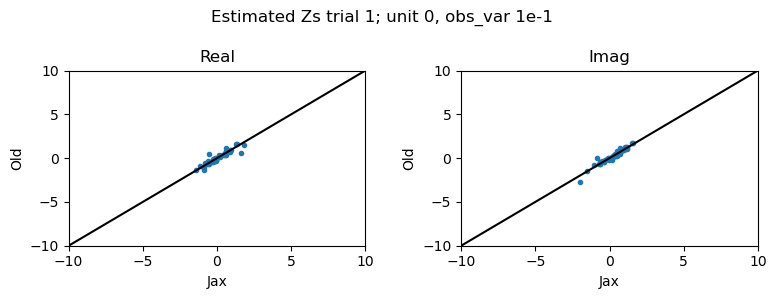

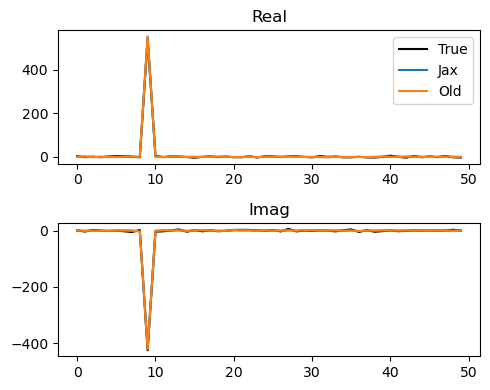

In [ ]:
mj = jax_exp.mus[:,:,trial]
mo = oldmod_exp.mus[:,:,trial]

k = 0
# plot_jvo(gj, go, k, plim, f'Grad trial {trial}; unit {k}, obs_var 1e{ov2}', showyx=False)
plot_jvo(mj, mo, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
# fig, ax = plt.subplots(figsize=(5,2))
# ax.plot(obs[:,k,trial])
# ax.set_xlabel('Time')
# ax.set_title(f'Observations trial {trial}; unit{k}; obs_var 1e{ov2}')

fig, ax = plt.subplots(2,1,figsize=(5,4))

ax[0].plot(zs[nz,k,trial].real, color='k', label='True')
ax[0].plot(jax_exp.mus[:,k,trial].real, label='Jax')
ax[0].plot(oldmod_exp.mus[:,k,trial].real, label='Old')
ax[0].set_title(f'Real')
ax[0].legend()

ax[1].plot(zs[nz,k,trial].imag, color='k', label='True')
ax[1].plot(jax_exp.mus[:,k,trial].imag, label='Jax')
ax[1].plot(oldmod_exp.mus[:,k,trial].imag, label='Old')
ax[1].set_title(f'Imag')
plt.tight_layout()

In [4]:

plim = 10
# plim = None
r = 9
trial = 2 

# mj = jax_exp.mus[:,:,trial]
# mo = old_exp.mus[:,:,trial]

mj = jax_exp.track_data[trial].track_zs[r]
mo = old_exp.track_data[trial].track_zs[r]
mom = oldmod_exp.track_data[trial].track_zs[r]


k = 0
# plot_jvo(gj, go, k, plim, f'Grad trial {trial}; unit {k}, obs_var 1e{ov2}', showyx=False)
# plot_jvo(mj, mo, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
# plot_jvo(mj, mom, k, plim, f'Estimated Zs trial {trial}; unit {k}, obs_var 1e{ov2}')
fig, axes = plt.subplots(2,5,figsize=(12,4))
yxline = jnp.linspace(-plim, plim, 100)
for rm1, ax in enumerate(axes.flat):
    r = rm1+1
    mj = jax_exp.track_data[trial].track_zs[r][:,k]
    mo = old_exp.track_data[trial].track_zs[r][:,k]

    ax.plot(mj, mo, '.')
    ax.set_xlim([-plim,plim])
    ax.set_ylim([-plim,plim])
    ax.plot(yxline,yxline,'k')
    ax.set_title(f'Iter {r}')
    if r in [1,6]:
        ax.set_ylabel('Old')
    if r >= 5:
        ax.set_xlabel('Jax')
plt.tight_layout()

fig, axes = plt.subplots(2,5,figsize=(12,4))
yxline = jnp.linspace(-plim, plim, 100)
for rm1, ax in enumerate(axes.flat):
    r = rm1+1
    mj = jax_exp.track_data[trial].track_zs[r][:,k]
    mom = oldmod_exp.track_data[trial].track_zs[r][:,k]

    ax.plot(mj, mom, '.')
    ax.set_xlim([-plim,plim])
    ax.set_ylim([-plim,plim])
    ax.plot(yxline,yxline,'k')
    ax.set_title(f'Iter {r}')
    if r in [1,6]:
        ax.set_ylabel('Old Mod')
    if r >= 5:
        ax.set_xlabel('Jax')
plt.tight_layout()

NameError: name 'jax_exp' is not defined

In [ ]:
trial = 0
# zs_test = jnp.zeros((Nnz, K), dtype=complex)
zs_test = zs[nz,:,trial]
omcost, omgrad, omhess = oldmod_exp.eval_cost(trial, zs_test)
ocost, ograd, ohess = old_exp.eval_cost(trial, zs_test)
jcost, jgrad, jhess = jax_exp.eval_cost(trial, zs_test)

In [ ]:
jax_trial = JaxOptim(obs[:,:,trial], gamma_inv_use, params_jax)

In [ ]:
print(omcost)
print(jcost)
print(omcost)

1057.3275
(1044.2009-2.4606578e-07j)
1057.3275


In [ ]:
k = 0
i = 0
print(ograd[i:i+2,k])
print(jgrad[i:i+2,k])
print(omgrad[i:i+2,k])

[ 0.14691877+0.12725976j -0.09913182+0.28590098j]
[ 0.30658355-0.0549341j  -0.2137658 +0.40776813j]
[ 0.3076854 -0.05654915j -0.21219519+0.4029864j ]


In [ ]:
k = 0
i = 0
j = 0
print(jnp.diag(ohess[j,:,:]))
print(jnp.diag(jhess[j,:,:]))
print(jnp.diag(omhess[j,:,:]))

[0.13984048+0.j 0.13984048+0.j]
[0.22-1.0803342e-10j 0.22-1.0803342e-10j]
[0.21992025+0.j 0.21992025+0.j]


Next 
- confirm Jax hessian is doing what it should do (recall it produces (n,k,n,k) matrix)
    - confirmed - see `compare_jax_vs_old_check_jhess.ipynb`
- illustrate out what was going wrong (correct the math / computation)
- confirm Old Mod works with scipy optimization 
- move on to point process observations and K > 2 
